In [2]:
import random
random.seed(234)

In [3]:
import pandas as pd

df = pd.read_csv("most_probable_structure.csv")
df.head()

,id,sequence,structure,score,package
0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.................................................,0.557927,contrafold_2
1,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.......((((.......))))...........................,0.628510,vienna_2
2,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).))................((......,0.698580,rnastructure
3,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,0.892884,contrafold_2
4,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,0.942417,vienna_2


In [4]:
# Calcola la lunghezza di ogni sequenza
df['seq_length'] = df['sequence'].apply(len)

# Trova la lunghezza più comune
most_common_length = df['seq_length'].mode()[0]

# Filtra solo le righe con quella lunghezza
df_sl = df[df['seq_length'] == most_common_length].reset_index(drop=True)

# Visualizza le prime righe
print(df_sl.head())
len(df_sl)

             id                                           sequence  \
0  id_001f94081  GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...   
1  id_001f94081  GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...   
2  id_001f94081  GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...   
3  id_0049f53ba  GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...   
4  id_0049f53ba  GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...   

                                           structure     score       package  \
0  .................................................  0.557927  contrafold_2   
1  .......((((.......))))...........................  0.628510      vienna_2   
2  .....((((((.......)))).))................((......  0.698580  rnastructure   
3  .....(((((((((((((((((((((((....)))))))))).)))...  0.892884  contrafold_2   
4  .....(((((((((((((((((((((((....)))))))))).)))...  0.942417      vienna_2   

   seq_length  
0         107  
1         107  
2         107  
3         107  
4         107  


39

In [5]:
import random

# Validatore per struttura dot-bracket
def is_valid_dot_bracket(struct):
    stack = []
    for char in struct:
        if char == '(':
            stack.append('(')
        elif char == ')':
            if not stack:
                return False
            stack.pop()
    return len(stack) == 0

# Rotazione circolare
def circular_shift(seq, struct, k):
    k = k % len(seq)
    return seq[k:] + seq[:k], struct[k:] + struct[:k]


In [6]:
def generate_circular_shifts(seq, struct, max_aug=10000):
    
    length = len(seq)
    shifts = set()  # per evitare duplicati
    augmented = []

    attempts = 0
    while len(augmented) < max_aug and attempts < length:
        k = random.randint(1, length - 1)
        if k in shifts:
            continue
        shifts.add(k)
        shifted_seq, shifted_struct = circular_shift(seq, struct, k)
        if is_valid_dot_bracket(shifted_struct):
            augmented.append((shifted_seq, shifted_struct))
        attempts += 1

    return augmented


In [7]:
augmented_data = []

for _, row in df_sl.iterrows():
    seq, struct = row['sequence'], row['structure']
    augmented_data.append((seq, struct))  # include originale
    augmented_data.extend(generate_circular_shifts(seq, struct, max_aug=3))

aug_df = pd.DataFrame(augmented_data, columns=["sequence", "structure"])


In [ ]:
import pandas as pd

# Assicurati che entrambi i DataFrame abbiano le stesse colonne
aug_df.columns = ['sequence', 'structure']
df_original = df_sl[['sequence', 'structure']].copy()

# Unisci i due DataFrame
combined_df = pd.concat([df_original, aug_df], ignore_index=True)

# Rimuovi duplicati se necessario
combined_df.drop_duplicates(inplace=True)

# Salva il dataset combinato su disco
combined_df.to_csv("complete_dataset_428bits.csv", index=False)

# (Opzionale) Visualizza le prime righe e il numero totale di righe
print(combined_df.head())
print("Totale sequenze nel dataset combinato:", len(combined_df))


                                            sequence  \
0  GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...   
1  GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...   
2  GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...   
3  GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...   
4  GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...   

                                           structure  
0  .................................................  
1  .......((((.......))))...........................  
2  .....((((((.......)))).))................((......  
3  .....(((((((((((((((((((((((....)))))))))).)))...  
4  .....(((((((((((((((((((((((....)))))))))).)))...  
Totale sequenze nel dataset combinato: 147


In [9]:
# Funzione per codificare basi (A, U, C, G) in 2 bit
def encode_base(base):
    return {
        'A': [0, 0],
        'C': [0, 1],
        'G': [1, 0],
        'U': [1, 1]
    }.get(base, [0, 0])  # default A

# Funzione per codificare dot-bracket in 2 bit
def encode_structure(symbol):
    return {
        '.': [0, 0],
        '(': [0, 1],
        ')': [1, 0]
    }.get(symbol, [0, 0])  # default '.'

# Funzione combinata: prima codifica sequenza, poi struttura, poi concatena
def encode_sequence_and_structure(seq, struct):
    encoded_seq = []
    encoded_struct = []
    for b in seq:
        encoded_seq += encode_base(b)
    for s in struct:
        encoded_struct += encode_structure(s)
    return encoded_seq + encoded_struct  # concatenazione

# Applichiamo la codifica al dataset filtrato
encoded_rows = [
    encode_sequence_and_structure(row['sequence'], row['structure'])
    for _, row in combined_df.iterrows()
]

# Mostriamo il risultato per la prima riga codificata
print(encoded_rows[0][214:428])  # primi 64 bit (ora primi 32 nt o simboli codificati)
len(encoded_rows[0]) 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


428

COMPLETE BITS

Epoch 10/10000, Loss: 0.498846
Epoch 20/10000, Loss: 0.450612
Epoch 30/10000, Loss: 0.415471
Epoch 40/10000, Loss: 0.385605
Epoch 50/10000, Loss: 0.355099
Epoch 60/10000, Loss: 0.324605
Epoch 70/10000, Loss: 0.294299
Epoch 80/10000, Loss: 0.263407
Epoch 90/10000, Loss: 0.233735
Epoch 100/10000, Loss: 0.201532
Epoch 110/10000, Loss: 0.173797
Epoch 120/10000, Loss: 0.148101
Epoch 130/10000, Loss: 0.124553
Epoch 140/10000, Loss: 0.102996
Epoch 150/10000, Loss: 0.085281
Epoch 160/10000, Loss: 0.071120
Epoch 170/10000, Loss: 0.057663
Epoch 180/10000, Loss: 0.047114
Epoch 190/10000, Loss: 0.038395
Epoch 200/10000, Loss: 0.031718
Epoch 210/10000, Loss: 0.025423
Epoch 220/10000, Loss: 0.021323
Epoch 230/10000, Loss: 0.017481
Epoch 240/10000, Loss: 0.014871
Epoch 250/10000, Loss: 0.012462
Epoch 260/10000, Loss: 0.010355
Epoch 270/10000, Loss: 0.008990
Epoch 280/10000, Loss: 0.007635
Epoch 290/10000, Loss: 0.006554
Epoch 300/10000, Loss: 0.005665
Epoch 310/10000, Loss: 0.004957
Epoch 320/10000, 

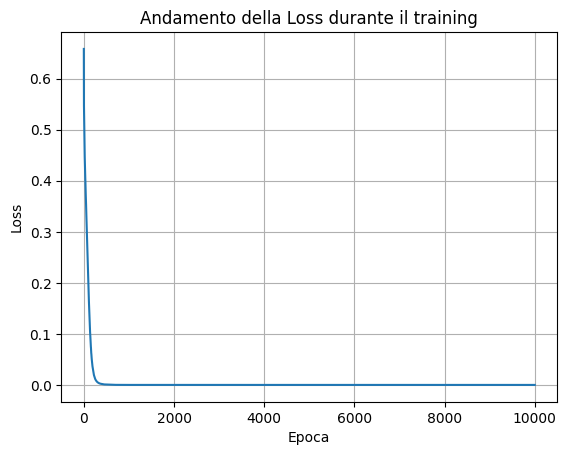

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Parametri configurabili
# -------------------------
LATENT_DIM = 48
EPOCHS = 10000
BATCH_SIZE = 14
LEARNING_RATE = 1e-3
MODEL_PATH = "best_autoencoder_model_48.pt"

# -------------------------
# Prepara i dati
# -------------------------
X = np.array(encoded_rows, dtype=np.float32)
input_dim = X.shape[1]
X_tensor = torch.tensor(X)

# -------------------------
# Definizione autoencoder binario
# -------------------------
class BinaryAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 388),
            nn.ReLU(),
            nn.Linear(388, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
            nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 388),
            nn.ReLU(),
            nn.Linear(388, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        z_binary = torch.round(z)
        x_hat = self.decoder(z_binary)
        return x_hat, z_binary

# -------------------------
# Inizializzazione
# -------------------------
model = BinaryAutoencoder(input_dim, LATENT_DIM)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# -------------------------
# Training loop con salvataggio della best loss
# -------------------------
loss_history = []
best_loss = float('inf')

dataset = torch.utils.data.TensorDataset(X_tensor)
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for batch in loader:
        x_batch = batch[0]
        optimizer.zero_grad()
        x_hat, _ = model(x_batch)
        loss = criterion(x_hat, x_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * x_batch.size(0)

    avg_loss = epoch_loss / len(dataset)
    loss_history.append(avg_loss)

    # Salva modello se loss è la migliore
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), MODEL_PATH)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.6f}")

# -------------------------
# Caricamento modello migliore
# -------------------------
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

# -------------------------
# Ricostruzione delle sequenze
# -------------------------
with torch.no_grad():
    reconstructed, latent_codes = model(X_tensor)

# Esempio: stampa una ricostruzione (bit arrotondati)
original_bits = X_tensor[0].numpy().astype(int)
reconstructed_bits = torch.round(reconstructed[0]).numpy().astype(int)
print("Originale:    ", original_bits[:64])
print("Ricostruzione:", reconstructed_bits[:64])
print("Latente bin.:", latent_codes[0].numpy().astype(int))

# -------------------------
# Visualizzazione della curva di loss
# -------------------------
plt.plot(loss_history)
plt.xlabel("Epoca")
plt.ylabel("Loss")
plt.title("Andamento della Loss durante il training")
plt.grid(True)
plt.show()


In [11]:
with torch.no_grad():
    reconstructed, latent_codes = model(X_tensor)


In [12]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# y_true: vettori binari originali
# y_pred: vettori binari ricostruiti (sostituisci questi con l’output reale del tuo modello se disponibile)
y_true = np.array(encoded_rows).astype(int).flatten()
y_pred = np.round(np.array(reconstructed)).astype(int).flatten()  # simulazione (sostituisci con output reale)

# Metriche classiche
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Hamming distance (numero di bit diversi)
hamming_distance = np.sum(y_true != y_pred)
normalized_hamming = hamming_distance / len(y_true)

# Stampa delle metriche
print(f"Accuracy:           {acc:.4f}")
print(f"Precision:          {prec:.4f}")
print(f"Recall:             {rec:.4f}")
print(f"F1-score:           {f1:.4f}")
print(f"Hamming Distance:   {hamming_distance}")
print(f"Hamming (norm.):    {normalized_hamming:.4f}")



Accuracy:           1.0000
Precision:          1.0000
Recall:             1.0000
F1-score:           1.0000
Hamming Distance:   0
Hamming (norm.):    0.0000


In [13]:

latent_binary = latent_codes.numpy().astype(int)

# Verifica dimensione
print("Shape del centro del bottleneck:", latent_binary.shape)

# (Facoltativo) salva come CSV
np.savetxt("latent_147x48.csv", latent_binary, fmt="%d", delimiter=",")

# Ritorna la matrice se serve in altro codice
latent_binary 


Shape del centro del bottleneck: (147, 48)


array([[1, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 1],
       [1, 0, 1, ..., 0, 0, 1]])

FEW BITS

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# Parametri configurabili
# -------------------------
LATENT_DIM = 14
EPOCHS = 100000
BATCH_SIZE = 10
LEARNING_RATE = 2e-4
MODEL_PATH = "best_autoencoder_model_12.pt"

# -------------------------
# Prepara i dati
# -------------------------
df = pd.read_csv("latent_147x48.csv")
X = df.values.astype(np.float32)
input_dim = X.shape[1]
X_tensor = torch.tensor(X)

# -------------------------
# Definizione autoencoder binario
# -------------------------
class BinaryAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 36),
            nn.ReLU(),
            nn.Linear(36, 20),
            nn.ReLU(),
            nn.Linear(20, latent_dim),
            nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 20),
            nn.ReLU(),
            nn.Linear(20, 36),
            nn.ReLU(),
            nn.Linear(36, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        z_binary = torch.round(z)
        x_hat = self.decoder(z_binary)
        return x_hat, z_binary

# -------------------------
# Inizializzazione
# -------------------------
model = BinaryAutoencoder(input_dim, LATENT_DIM)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# -------------------------
# Training loop con salvataggio della best loss
# -------------------------
loss_history = []
best_loss = float('inf')

dataset = torch.utils.data.TensorDataset(X_tensor)
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for batch in loader:
        x_batch = batch[0]
        optimizer.zero_grad()
        x_hat, _ = model(x_batch)
        loss = criterion(x_hat, x_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * x_batch.size(0)

    avg_loss = epoch_loss / len(dataset)
    loss_history.append(avg_loss)

    # Salva modello se loss è la migliore
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), MODEL_PATH)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.6f}")

# -------------------------
# Caricamento modello migliore
# -------------------------
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

# -------------------------
# Ricostruzione delle sequenze
# -------------------------
with torch.no_grad():
    reconstructed, latent_codes = model(X_tensor)

# Esempio: stampa una ricostruzione (bit arrotondati)
original_bits = X_tensor[0].numpy().astype(int)
reconstructed_bits = torch.round(reconstructed[0]).numpy().astype(int)
print("Originale:    ", original_bits)
print("Ricostruzione:", reconstructed_bits)
print("Latente bin.:", latent_codes[0].numpy().astype(int))

# -------------------------
# Visualizzazione della curva di loss
# -------------------------
plt.plot(loss_history)
plt.xlabel("Epoca")
plt.ylabel("Loss")
plt.title("Andamento della Loss durante il training")
plt.grid(True)
plt.show()


Epoch 10/100000, Loss: 0.598066
Epoch 20/100000, Loss: 0.356817
Epoch 30/100000, Loss: 0.313790
Epoch 40/100000, Loss: 0.304875
Epoch 50/100000, Loss: 0.301476
Epoch 60/100000, Loss: 0.299637
Epoch 70/100000, Loss: 0.298321
Epoch 80/100000, Loss: 0.297343
Epoch 90/100000, Loss: 0.296455
Epoch 100/100000, Loss: 0.295527
Epoch 110/100000, Loss: 0.293987
Epoch 120/100000, Loss: 0.292256
Epoch 130/100000, Loss: 0.290575
Epoch 140/100000, Loss: 0.289028
Epoch 150/100000, Loss: 0.287487
Epoch 160/100000, Loss: 0.286128
Epoch 170/100000, Loss: 0.284816
Epoch 180/100000, Loss: 0.283728
Epoch 190/100000, Loss: 0.282776
Epoch 200/100000, Loss: 0.281988
Epoch 210/100000, Loss: 0.281315
Epoch 220/100000, Loss: 0.280685
Epoch 230/100000, Loss: 0.280152
Epoch 240/100000, Loss: 0.279664
Epoch 250/100000, Loss: 0.279257
Epoch 260/100000, Loss: 0.278863
Epoch 270/100000, Loss: 0.278451
Epoch 280/100000, Loss: 0.278151
Epoch 290/100000, Loss: 0.277773
Epoch 300/100000, Loss: 0.277438
Epoch 310/100000, L

KeyboardInterrupt: 

Epoch 10/50000, Loss: 0.608969
Epoch 20/50000, Loss: 0.559048
Epoch 30/50000, Loss: 0.543317
Epoch 40/50000, Loss: 0.534373
Epoch 50/50000, Loss: 0.527051
Epoch 60/50000, Loss: 0.520498
Epoch 70/50000, Loss: 0.514660
Epoch 80/50000, Loss: 0.509500
Epoch 90/50000, Loss: 0.504921
Epoch 100/50000, Loss: 0.500906
Epoch 110/50000, Loss: 0.497256
Epoch 120/50000, Loss: 0.493976
Epoch 130/50000, Loss: 0.491056
Epoch 140/50000, Loss: 0.488457
Epoch 150/50000, Loss: 0.485874
Epoch 160/50000, Loss: 0.483605
Epoch 170/50000, Loss: 0.481440
Epoch 180/50000, Loss: 0.479459
Epoch 190/50000, Loss: 0.477563
Epoch 200/50000, Loss: 0.475795
Epoch 210/50000, Loss: 0.474084
Epoch 220/50000, Loss: 0.472446
Epoch 230/50000, Loss: 0.470858
Epoch 240/50000, Loss: 0.469331
Epoch 250/50000, Loss: 0.467922
Epoch 260/50000, Loss: 0.466420
Epoch 270/50000, Loss: 0.465076
Epoch 280/50000, Loss: 0.463681
Epoch 290/50000, Loss: 0.462330
Epoch 300/50000, Loss: 0.461049
Epoch 310/50000, Loss: 0.459717
Epoch 320/50000, 

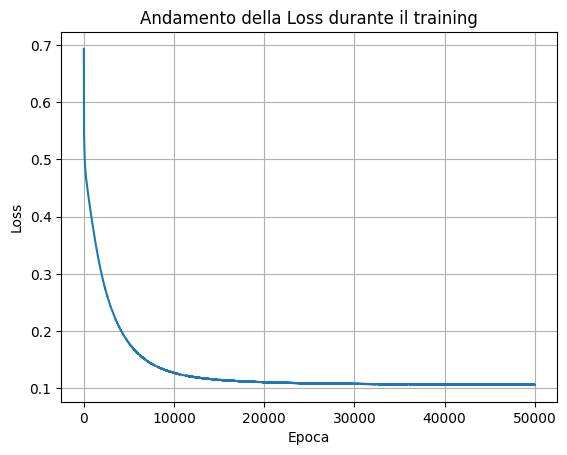

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Parametri configurabili
# -------------------------
LATENT_DIM = 14
EPOCHS = 50000
BATCH_SIZE = 10
LEARNING_RATE = 1e-4
MODEL_PATH = "best_autoencoder_model_14.pt"

# -------------------------
# Prepara i dati
# -------------------------
X = np.array(encoded_rows, dtype=np.float32)
input_dim = X.shape[1]
X_tensor = torch.tensor(X)

# -------------------------
# Definizione autoencoder binario
# -------------------------
class BinaryAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
    nn.Linear(input_dim, 256),
    nn.ReLU(),
    nn.Linear(256, latent_dim),
    nn.Sigmoid()
)

        self.decoder = nn.Sequential(
    nn.Linear(latent_dim, 256),
    nn.ReLU(),
    nn.Linear(256, input_dim),
    nn.Sigmoid()
)


    def forward(self, x):
        z = self.encoder(x)
        z_binary = torch.round(z)
        x_hat = self.decoder(z_binary)
        return x_hat, z_binary

# -------------------------
# Inizializzazione
# -------------------------
model = BinaryAutoencoder(input_dim, LATENT_DIM)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# -------------------------
# Training loop con salvataggio della best loss
# -------------------------
loss_history = []
best_loss = float('inf')

dataset = torch.utils.data.TensorDataset(X_tensor)
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for batch in loader:
        x_batch = batch[0]
        optimizer.zero_grad()
        x_hat, _ = model(x_batch)
        loss = criterion(x_hat, x_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * x_batch.size(0)

    avg_loss = epoch_loss / len(dataset)
    loss_history.append(avg_loss)

    # Salva modello se loss è la migliore
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), MODEL_PATH)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.6f}")

# -------------------------
# Caricamento modello migliore
# -------------------------
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

# -------------------------
# Ricostruzione delle sequenze
# -------------------------
with torch.no_grad():
    reconstructed, latent_codes = model(X_tensor)

# Esempio: stampa una ricostruzione (bit arrotondati)
original_bits = X_tensor[0].numpy().astype(int)
reconstructed_bits = torch.round(reconstructed[0]).numpy().astype(int)
print("Originale:    ", original_bits[:64])
print("Ricostruzione:", reconstructed_bits[:64])
print("Latente bin.:", latent_codes[0].numpy().astype(int))

# -------------------------
# Visualizzazione della curva di loss
# -------------------------
plt.plot(loss_history)
plt.xlabel("Epoca")
plt.ylabel("Loss")
plt.title("Andamento della Loss durante il training")
plt.grid(True)
plt.show()


In [27]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# y_true: vettori binari originali
# y_pred: vettori binari ricostruiti (sostituisci questi con l’output reale del tuo modello se disponibile)
y_true = np.array(encoded_rows).astype(int).flatten()
y_pred = np.round(np.array(reconstructed)).astype(int).flatten()  # simulazione (sostituisci con output reale)

# Metriche classiche
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Hamming distance (numero di bit diversi)
hamming_distance = np.sum(y_true != y_pred)
normalized_hamming = hamming_distance / len(y_true)

# Stampa delle metriche
print(f"Accuracy:           {acc:.4f}")
print(f"Precision:          {prec:.4f}")
print(f"Recall:             {rec:.4f}")
print(f"F1-score:           {f1:.4f}")
print(f"Hamming Distance:   {hamming_distance}")
print(f"Hamming (norm.):    {normalized_hamming:.4f}")



Accuracy:           0.9383
Precision:          0.9091
Recall:             0.8835
F1-score:           0.8961
Hamming Distance:   3880
Hamming (norm.):    0.0617


In [28]:

latent_binary = latent_codes.numpy().astype(int)

# Verifica dimensione
print("Shape del centro del bottleneck:", latent_binary.shape)

# (Facoltativo) salva come CSV
np.savetxt("latent_147x14.csv", latent_binary, fmt="%d", delimiter=",")

# Ritorna la matrice se serve in altro codice
latent_binary 


Shape del centro del bottleneck: (147, 14)


array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 1, 0],
       [0, 1, 1, ..., 0, 1, 0],
       [0, 1, 1, ..., 0, 1, 0]])